In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tsai.all import *
import sys
sys.path.append("..")
from util import get_segments_by_hour, pad_sequence, cpc_to_label

In [2]:
path_to_data = Path("/media/nvme1/icare-data/features")

In [3]:
removed_patient = []
dataset = []
labels = []
for patient in path_to_data.iterdir():
    # Read in the patient dataframe to obtain label
    df = pd.read_csv("/home/bc299/icare/patient_data.csv", dtype={"Patient": str})
    feature_files = get_segments_by_hour(patient, start_hour=0, end_hour=96)
    # Only keep patient data if there are more than 12 hours of recording. Also patient 0306 is missing records
    if (len(feature_files) < 12) or patient.name == "0306":
        removed_patient.append(patient.name)
    else:
        # Add the neurological recovery label for this patient
        cpc_value = df.loc[df["Patient"] == patient.name, "CPC"].iloc[0]
        labels.append(cpc_to_label(cpc_value))
        # Concatenate features for each hour to a single feature array
        features_list = []
        for feature_file in feature_files:
            # Load in the features 
            feature = np.load(feature_file)
            features_list.append(feature)
        features = np.concatenate(features_list, axis=1)
        dataset.append(features)

labels = np.array(labels)
print(f"Removed {len(removed_patient)} patients due to limited EEG recordings.")

Removed 37 patients due to limited EEG recordings.


In [4]:
padded_dataset = np.stack(pad_sequence(dataset))
print(f"Shape of dataset: {padded_dataset.shape} [# samples, # variables, seq_len]")

Shape of dataset: (570, 8, 1184) [# samples, # variables, seq_len]


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Split the data into train/val/test with 70/20/10%
X_temp, X_test, y_temp, y_test = train_test_split(padded_dataset, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(0.1 / 0.8), random_state=42)

In [6]:
X_train = np.nan_to_num(X_train)
X_val = np.nan_to_num(X_val)

In [30]:
bs = 16
tfms = [None, TSClassification()]
train_dataset = TSDatasets(X_train, y_train, tfms=tfms)
val_dataset = TSDatasets(X_val, y_val, tfms=tfms)
test_dataset = TSDatasets(X_test, y_test, tfms=tfms)

dls = TSDataLoaders.from_dsets(train_dataset, 
                                       val_dataset, 
                                       test_dataset,
                                       bs=bs,
                                       shuffle_train=True,
                                       batch_tfsm=TSStandardize())

In [44]:
model = GRU_FCN(dls.vars, dls.c, dls.len)
learner = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy])

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time


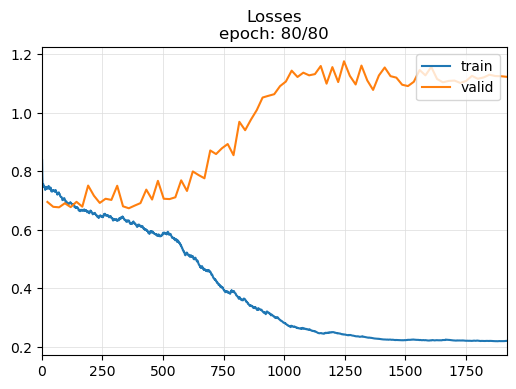

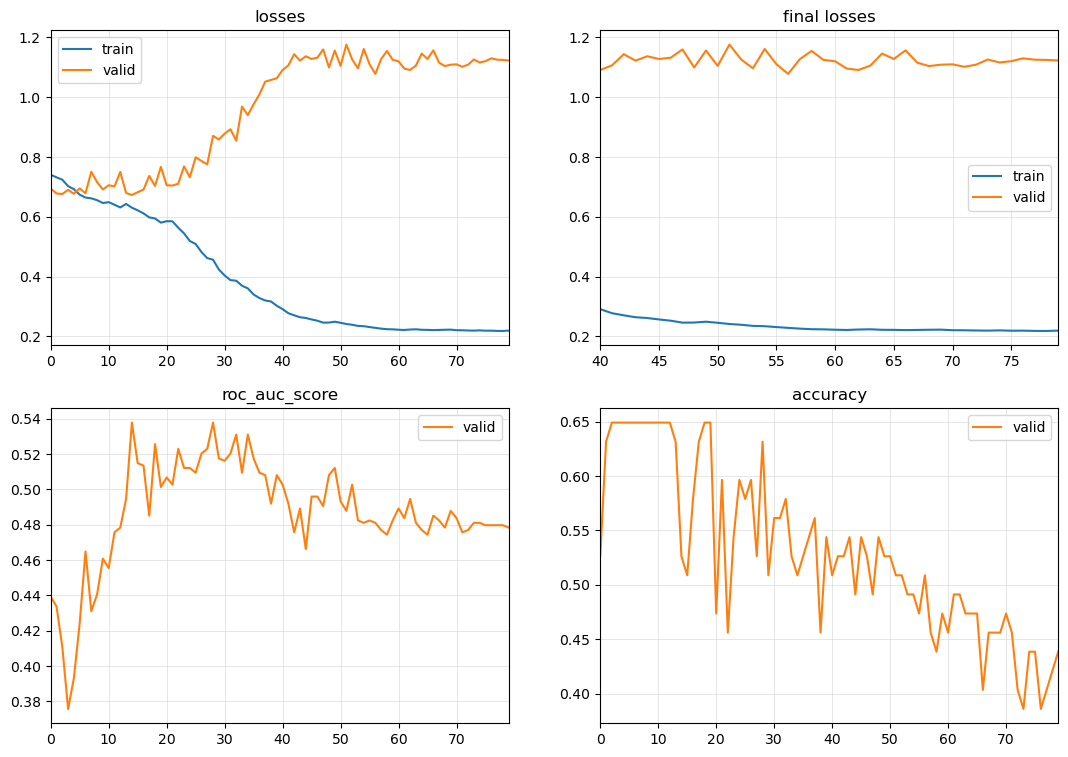

In [45]:
learner.fit_one_cycle(80, 1e-3, cbs=ShowGraphCallback2())